# **LOADING PACKAGES**

In [1]:
library(tidyverse)
library(corrplot)
library(gridExtra)
library(scales)
library(car)
library(lmtest)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


corrplot 0.92 loaded




Attaching package: ‘gridExtra’




The following object is masked from ‘package:dplyr’:

    combine





Attaching package: ‘scales’




The following object is masked from ‘package:purrr’:

    discard




The following object is masked from ‘package:readr’:

    col_factor




Loading required package: carData




Attaching package: ‘car’




The following object is masked from ‘package:dplyr’:

    recode




The following object is masked from ‘package:purrr’:

    some




Loading required package: zoo




Attaching package: ‘zoo’




The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




# **SET THEME FOR PLOTS**

In [2]:
# Set plot size for FULL WIDTH visualization in notebooks
options(repr.plot.width = 18, repr.plot.height = 9)

# Set elegant theme for plots with larger elements
theme_set(theme_minimal(base_size = 16) +
            theme(plot.title = element_text(face = "bold", size = 20, hjust = 0),
                  plot.subtitle = element_text(size = 16, color = "gray30", hjust = 0),
                  legend.position = "right",
                  legend.title = element_text(size = 14, face = "bold"),
                  legend.text = element_text(size = 13),
                  axis.title = element_text(size = 15, face = "bold"),
                  axis.text = element_text(size = 13),
                  plot.margin = margin(25, 25, 25, 25)))

# **1. LOADING AND INITIAL DATA EXPLORATION**


In [3]:
# Load dataset
data <- read.csv("/kaggle/input/insurance/insurance.csv")

# View structure
cat("DATASET STRUCTURE\n")
cat("=" , rep("=", 50), "\n", sep = "")
str(data)

DATASET STRUCTURE


'data.frame':	1338 obs. of  7 variables:
 $ age     : int  19 18 28 33 32 31 46 37 37 60 ...
 $ sex     : chr  "female" "male" "male" "male" ...
 $ bmi     : num  27.9 33.8 33 22.7 28.9 ...
 $ children: int  0 1 3 0 0 0 1 3 2 0 ...
 $ smoker  : chr  "yes" "no" "no" "no" ...
 $ region  : chr  "southwest" "southeast" "southeast" "northwest" ...
 $ charges : num  16885 1726 4449 21984 3867 ...


In [4]:
cat("\nDESCRIPTIVE STATISTICS\n")
cat("=" , rep("=", 50), "\n", sep = "")
summary(data)


DESCRIPTIVE STATISTICS


      age            sex                 bmi           children    
 Min.   :18.00   Length:1338        Min.   :15.96   Min.   :0.000  
 1st Qu.:27.00   Class :character   1st Qu.:26.30   1st Qu.:0.000  
 Median :39.00   Mode  :character   Median :30.40   Median :1.000  
 Mean   :39.21                      Mean   :30.66   Mean   :1.095  
 3rd Qu.:51.00                      3rd Qu.:34.69   3rd Qu.:2.000  
 Max.   :64.00                      Max.   :53.13   Max.   :5.000  
    smoker             region             charges     
 Length:1338        Length:1338        Min.   : 1122  
 Class :character   Class :character   1st Qu.: 4740  
 Mode  :character   Mode  :character   Median : 9382  
                                       Mean   :13270  
                                       3rd Qu.:16640  
                                       Max.   :63770  

# **2. DATA CLEANING**

In [5]:
cat("\nSTARTING DATA CLEANING\n")
cat("=" , rep("=", 50), "\n", sep = "")

# Check missing values
cat("\nMissing values per column:\n")
print(colSums(is.na(data)))

# Check duplicates
cat("\nDuplicate records:", sum(duplicated(data)), "\n")

# Remove duplicates if they exist
data <- data %>% distinct()

# Convert categorical variables to factors
data <- data %>%
  mutate(
    sex = as.factor(sex),
    smoker = as.factor(smoker),
    region = as.factor(region)
  )

# Check outliers in target variable
Q1 <- quantile(data$charges, 0.25)
Q3 <- quantile(data$charges, 0.75)
IQR_charges <- Q3 - Q1
outliers_count <- sum(data$charges < (Q1 - 1.5 * IQR_charges) | 
                        data$charges > (Q3 + 1.5 * IQR_charges))

cat("\nOutliers detected in 'charges':", outliers_count, "\n")
cat("✅ Data cleaned and prepared!\n")




STARTING DATA CLEANING



Missing values per column:


     age      sex      bmi children   smoker   region  charges 
       0        0        0        0        0        0        0 



Duplicate records: 1 



Outliers detected in 'charges': 139 


✅ Data cleaned and prepared!


# **3. EXPLORATORY ANALYSIS WITH VISUALIZATIONS**



📈 GENERATING EXPLORATORY VISUALIZATIONS


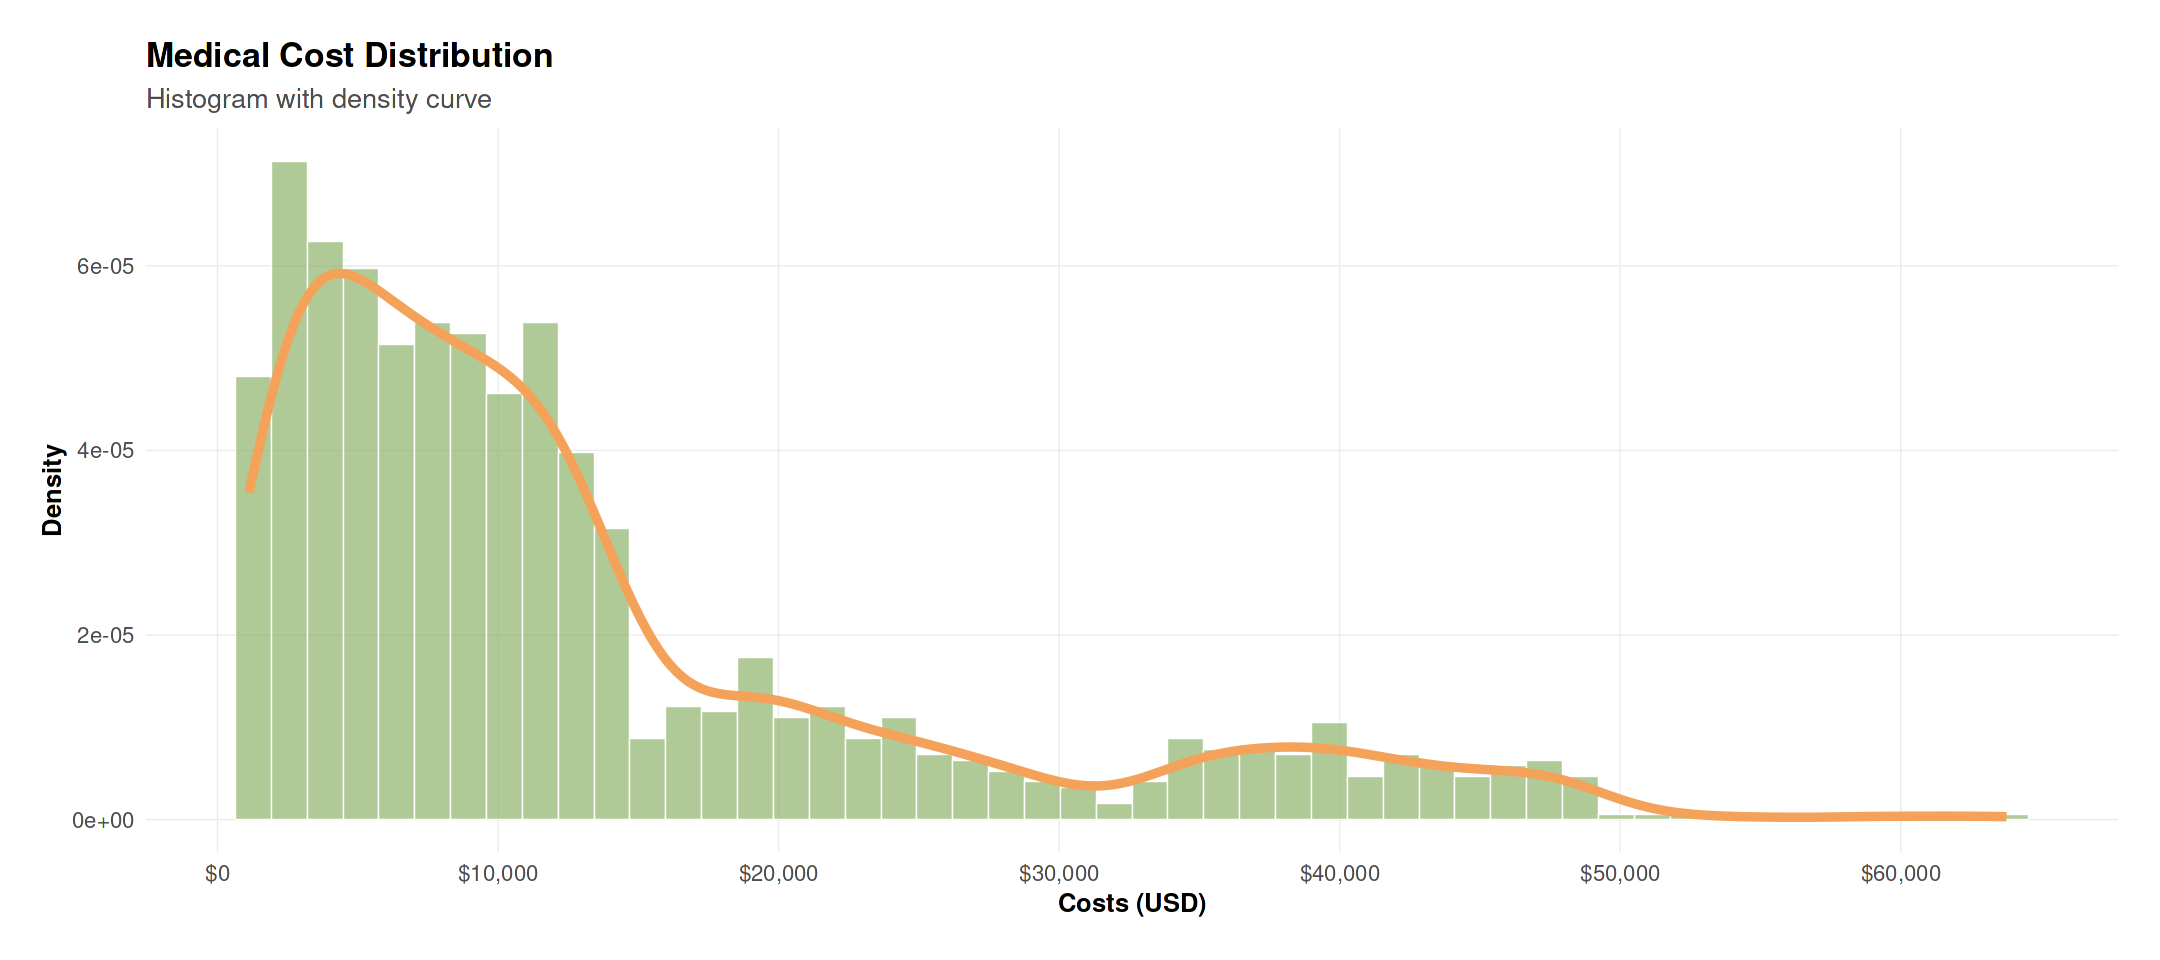

`geom_smooth()` using formula = 'y ~ x'


`geom_smooth()` using formula = 'y ~ x'


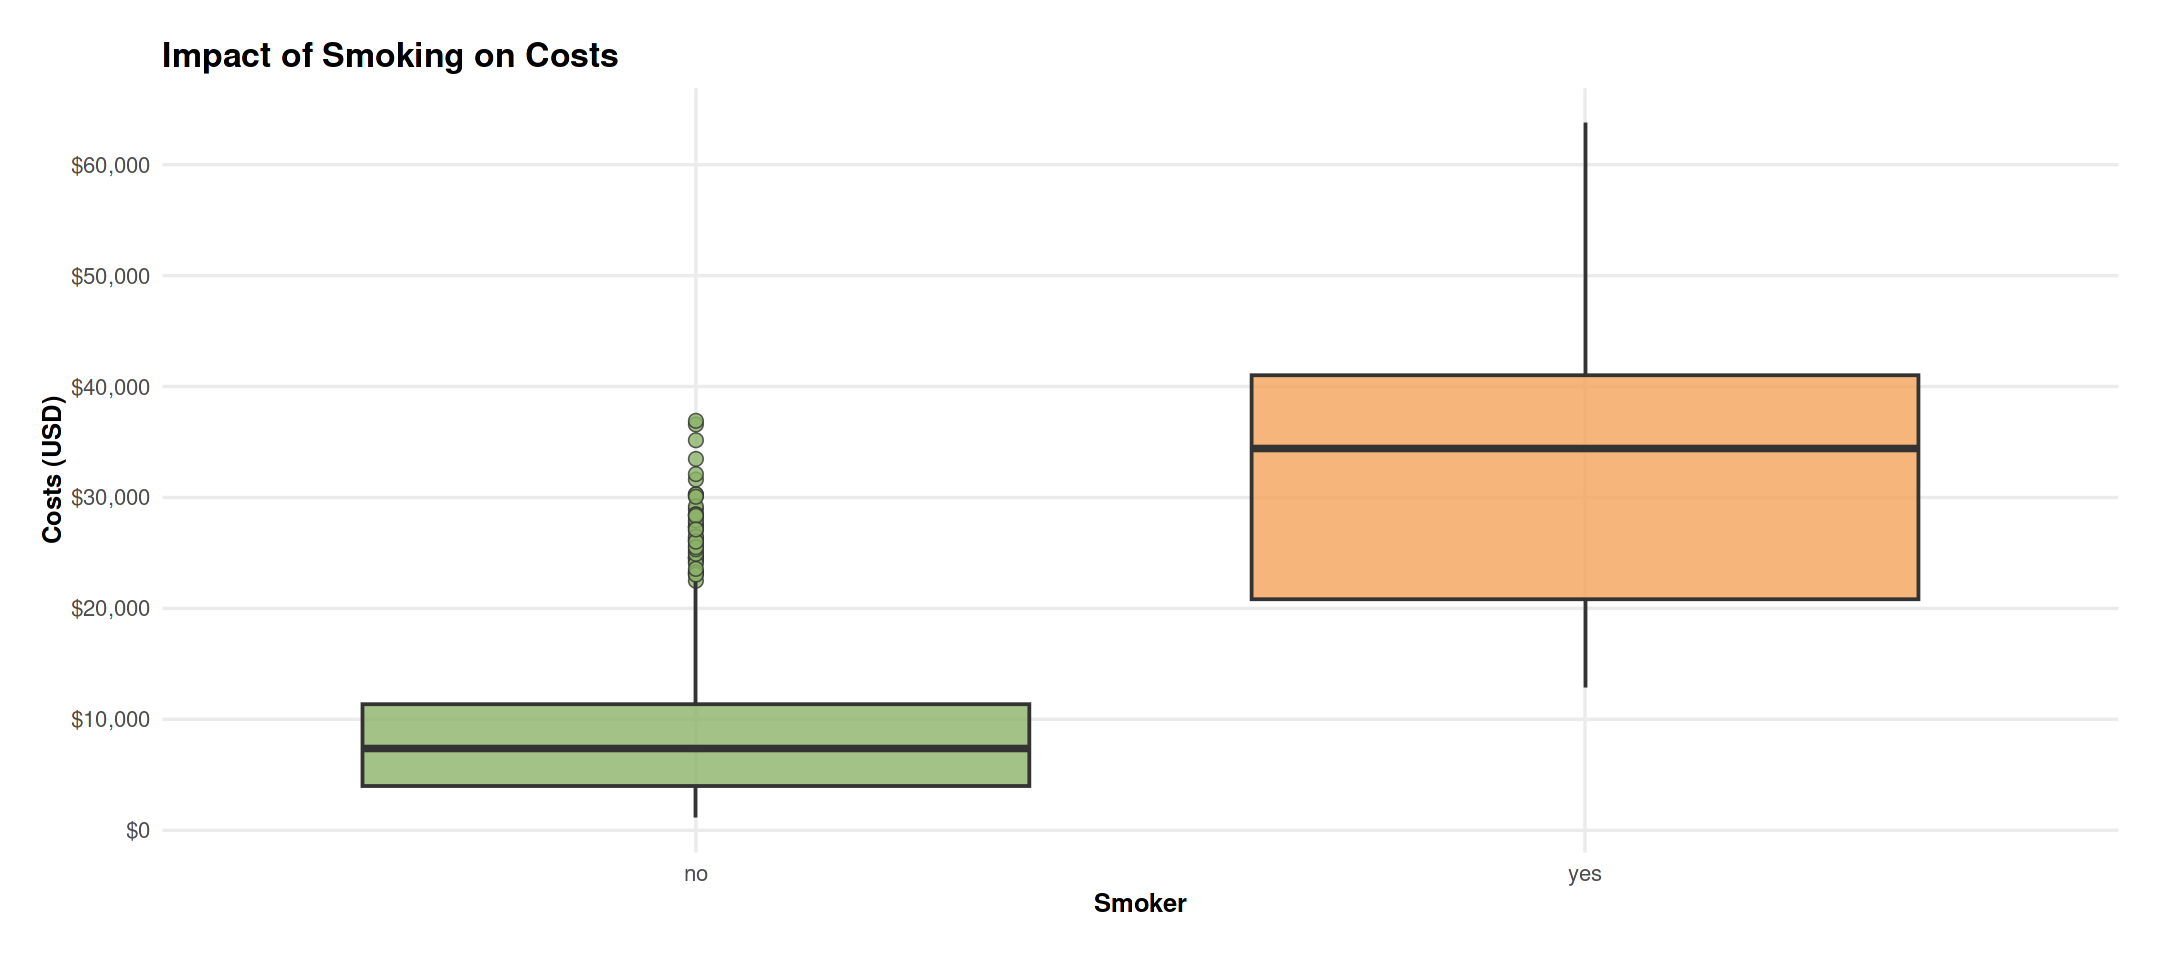

Warning message in ind1:ind2:
“numerical expression has 2 elements: only the first used”


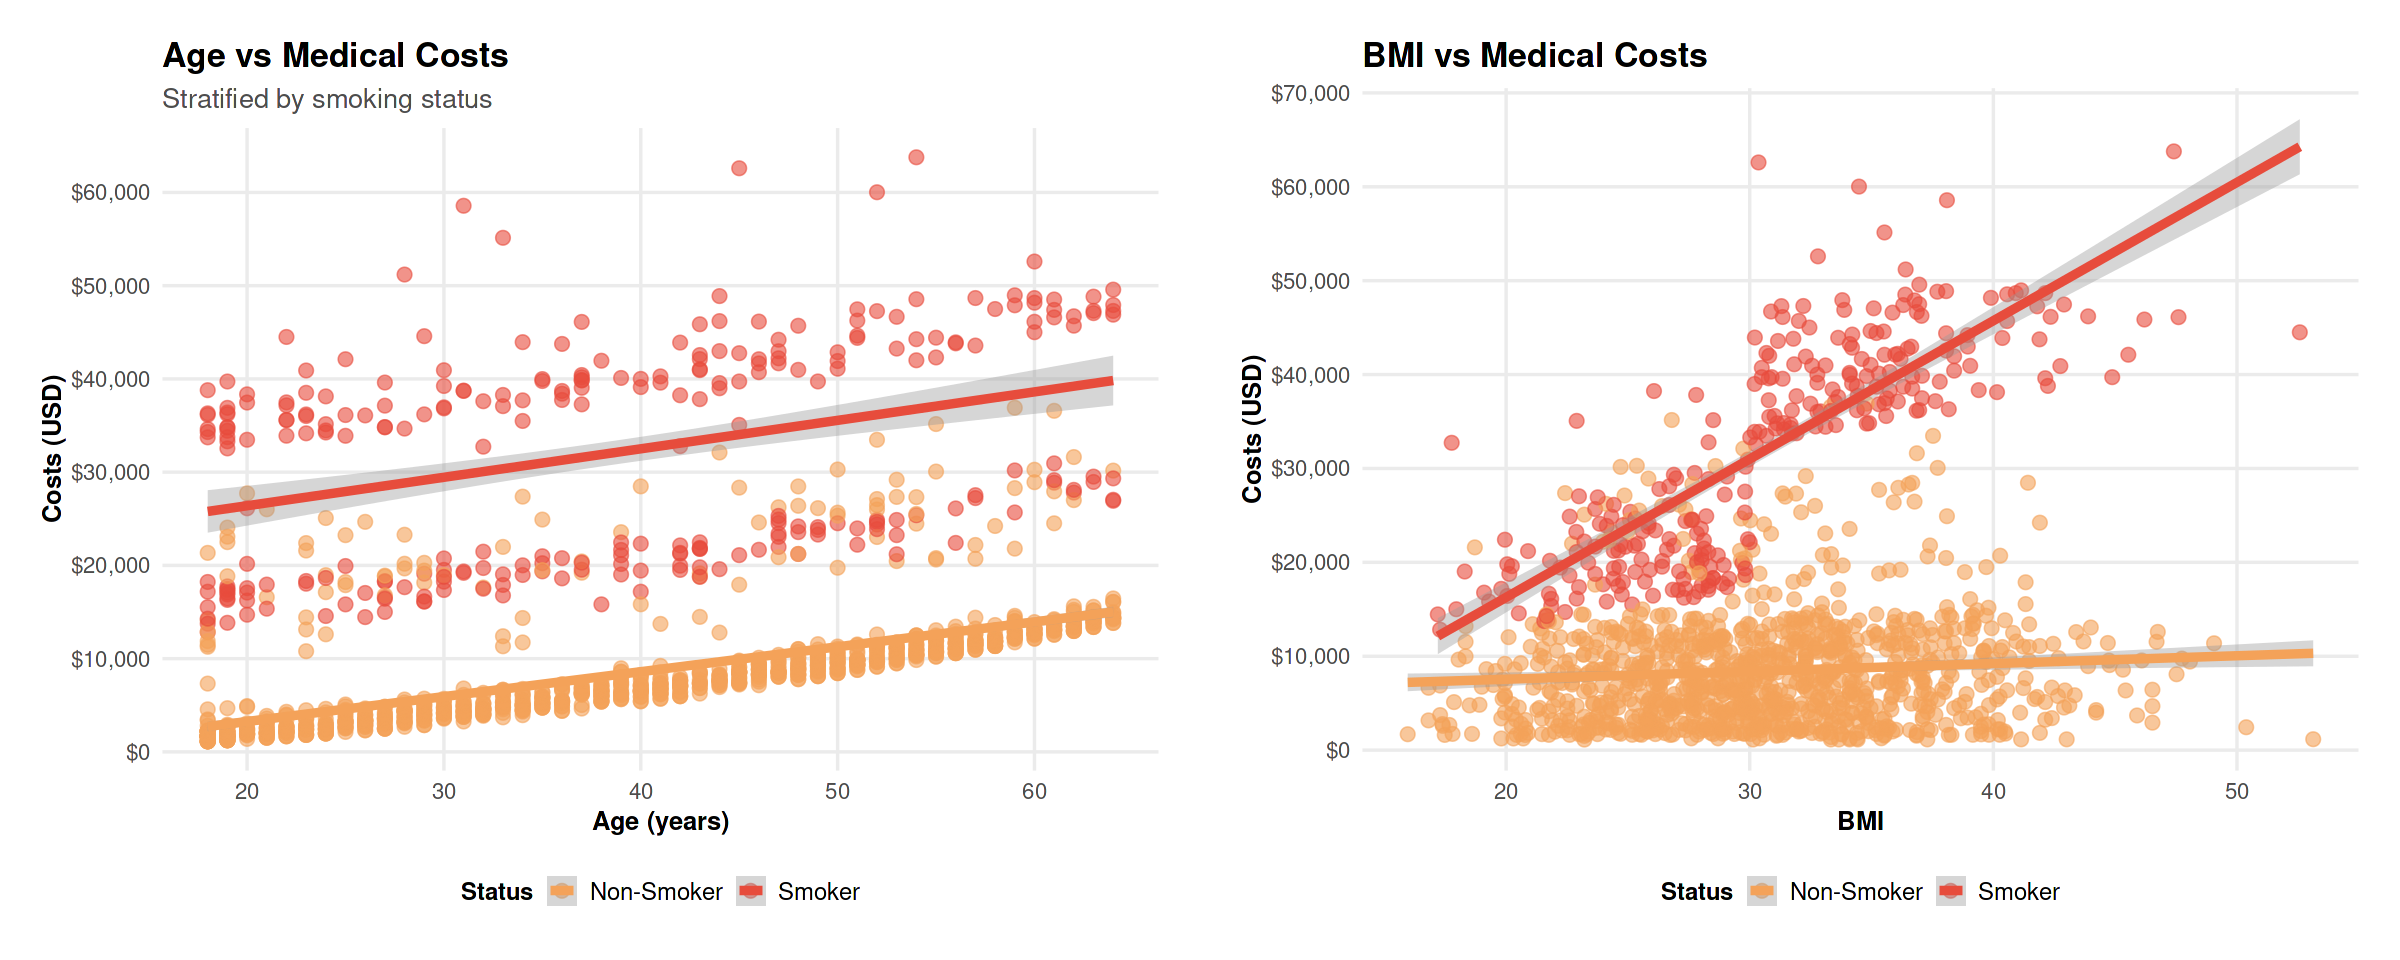

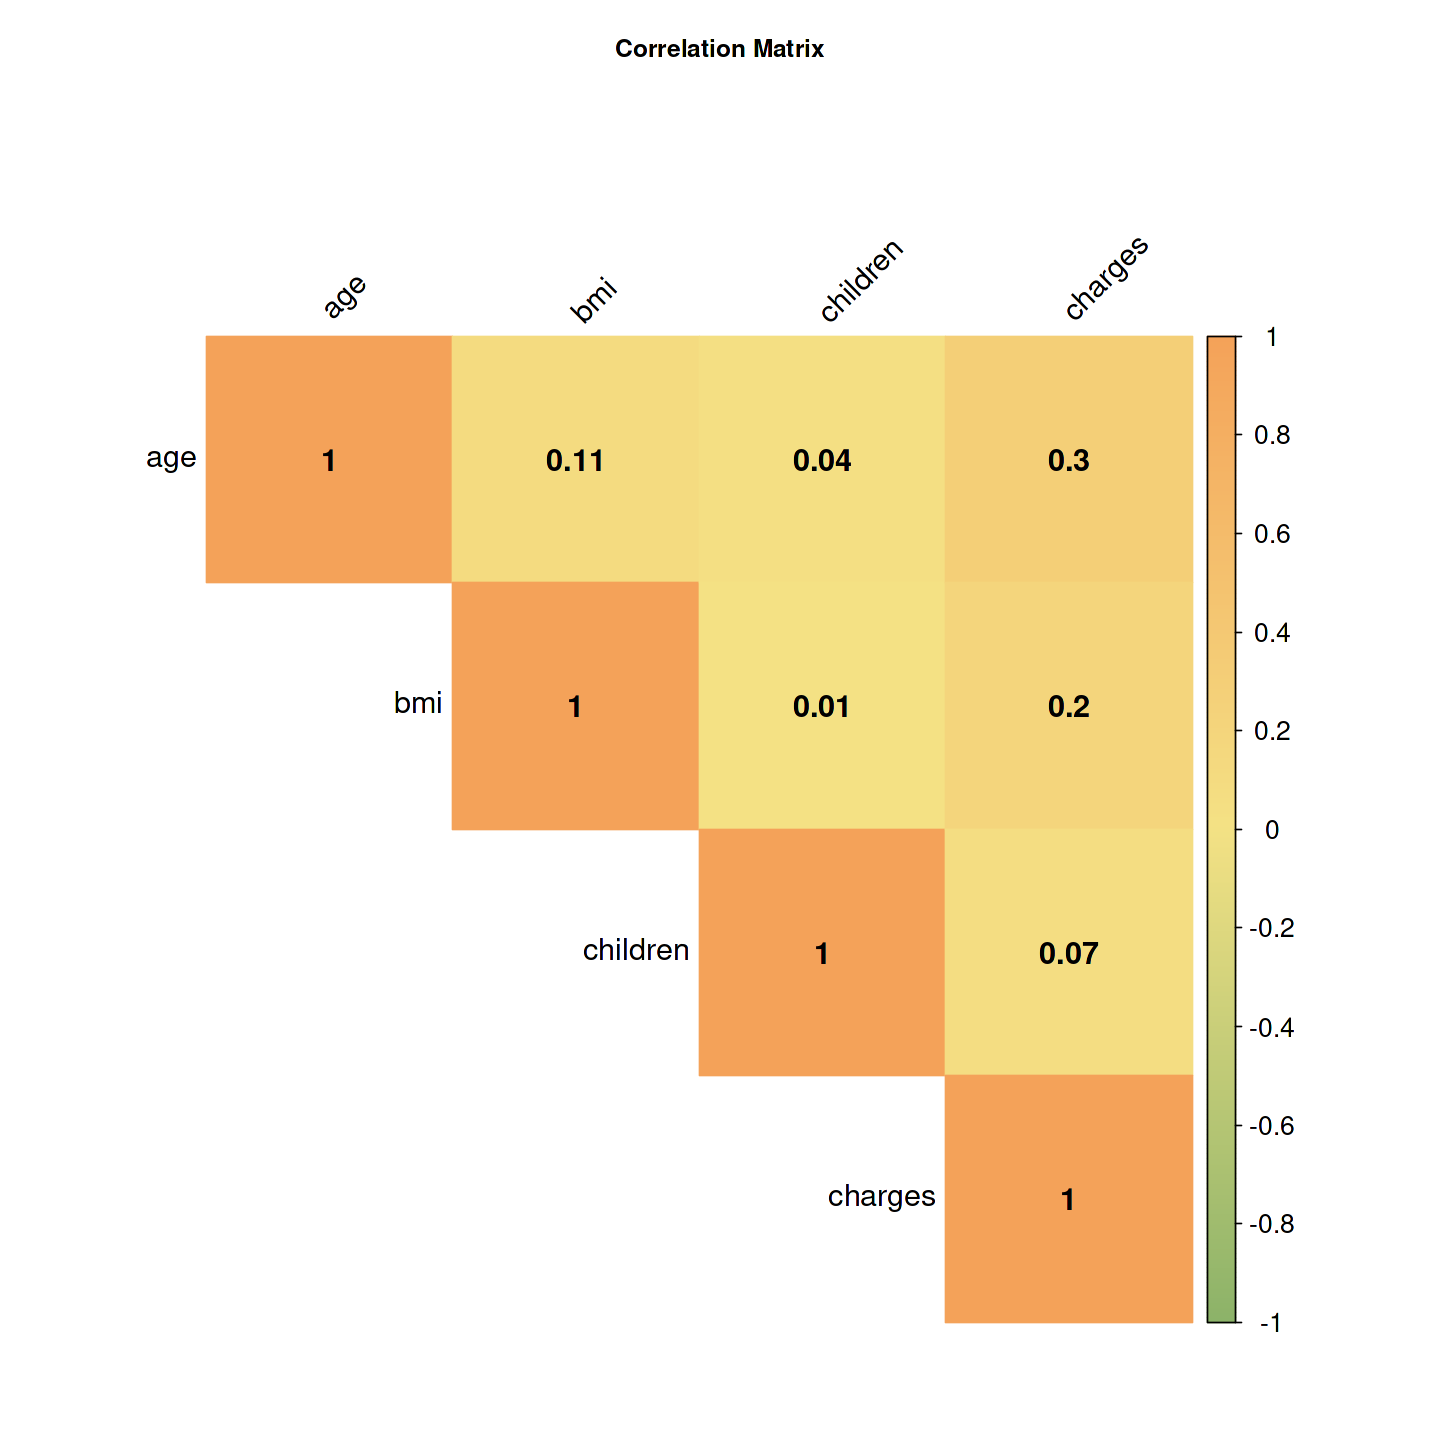

In [6]:
cat("\n📈 GENERATING EXPLORATORY VISUALIZATIONS\n")
cat("=" , rep("=", 50), "\n", sep = "")

# 3.1 Distribution of target variable (charges)
options(repr.plot.width = 18, repr.plot.height = 8)
p1 <- ggplot(data, aes(x = charges)) +
  geom_histogram(aes(y = after_stat(density)), bins = 50, 
                 fill = "#8cb369", alpha = 0.7, color = "white", linewidth = 0.3) +
  geom_density(color = "#f4a259", linewidth = 2) +
  scale_x_continuous(labels = dollar_format(prefix = "$"), 
                     breaks = seq(0, 70000, 10000)) +
  labs(title = "Medical Cost Distribution",
       subtitle = "Histogram with density curve",
       x = "Costs (USD)", y = "Density") +
  theme(panel.grid.minor = element_blank(),
        panel.grid.major = element_line(linewidth = 0.3))

# 3.2 Costs by smoking category
p2 <- ggplot(data, aes(x = smoker, y = charges, fill = smoker)) +
  geom_boxplot(alpha = 0.8, outlier.shape = 21, outlier.size = 3.5, linewidth = 0.8) +
  scale_fill_manual(values = c("#8cb369", "#f4a259")) +
  scale_y_continuous(labels = dollar_format(prefix = "$"),
                     breaks = seq(0, 70000, 10000)) +
  labs(title = "Impact of Smoking on Costs",
       x = "Smoker", y = "Costs (USD)") +
  theme(legend.position = "none",
        panel.grid.minor = element_blank())

# 3.3 Relationship between age and costs
p3 <- ggplot(data, aes(x = age, y = charges, color = smoker)) +
  geom_point(alpha = 0.6, size = 3.5) +
  geom_smooth(method = "lm", se = TRUE, linewidth = 2) +
  scale_color_manual(values = c("#f4a259", "#e74c3c"),
                     labels = c("Non-Smoker", "Smoker")) +
  scale_y_continuous(labels = dollar_format(prefix = "$"),
                     breaks = seq(0, 70000, 10000)) +
  labs(title = "Age vs Medical Costs",
       subtitle = "Stratified by smoking status",
       x = "Age (years)", y = "Costs (USD)",
       color = "Status") +
  theme(legend.position = "bottom",
        legend.text = element_text(size = 14),
        panel.grid.minor = element_blank())

# 3.4 BMI vs Costs
p4 <- ggplot(data, aes(x = bmi, y = charges, color = smoker)) +
  geom_point(alpha = 0.6, size = 3.5) +
  geom_smooth(method = "lm", se = TRUE, linewidth = 2) +
  scale_color_manual(values = c("#f4a259", "#e74c3c"),
                     labels = c("Non-Smoker", "Smoker")) +
  scale_y_continuous(labels = dollar_format(prefix = "$"),
                     breaks = seq(0, 70000, 10000)) +
  labs(title = "BMI vs Medical Costs",
       x = "BMI", y = "Costs (USD)",
       color = "Status") +
  theme(legend.position = "bottom",
        legend.text = element_text(size = 14),
        panel.grid.minor = element_blank())

# Display plots - FULL WIDTH
options(repr.plot.width = 18, repr.plot.height = 8)
print(p1)
print(p2)

# Display side-by-side plots - EXTRA WIDE
options(repr.plot.width = 20, repr.plot.height = 8)
grid.arrange(p3, p4, ncol = 2)

# 3.5 Correlation matrix - LARGE SIZE
options(repr.plot.width = 12, repr.plot.height = 12)
data_numeric <- data %>%
  select(age, bmi, children, charges) %>%
  cor()

corrplot(data_numeric, method = "color", type = "upper",
         addCoef.col = "black", number.cex = 1.5,
         tl.col = "black", tl.srt = 45, tl.cex = 1.5,
         col = colorRampPalette(c("#8cb369", "#f4e285", "#f4a259"))(200),
         title = "Correlation Matrix",
         mar = c(0,0,4,0), cl.cex = 1.3)


# **4. MODELING - MULTIPLE LINEAR REGRESSION**

In [7]:
cat("\nBUILDING LINEAR REGRESSION MODEL\n")
cat("=" , rep("=", 50), "\n", sep = "")

# Split data into train and test (80/20)
set.seed(123)
train_indices <- sample(1:nrow(data), 0.8 * nrow(data))
train_data <- data[train_indices, ]
test_data <- data[-train_indices, ]

cat("\nTraining set size:", nrow(train_data))
cat("\nTest set size:", nrow(test_data), "\n")

# Complete model
model <- lm(charges ~ age + sex + bmi + children + smoker + region, 
            data = train_data)

# Model summary
cat("\nMODEL SUMMARY\n")
cat("=" , rep("=", 50), "\n", sep = "")
print(summary(model))


BUILDING LINEAR REGRESSION MODEL



Training set size: 1069


Test set size: 268 



MODEL SUMMARY



Call:
lm(formula = charges ~ age + sex + bmi + children + smoker + 
    region, data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-11592.6  -2923.3   -993.5   1494.3  30033.2 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -11353.21    1133.33 -10.018  < 2e-16 ***
age                246.03      13.75  17.898  < 2e-16 ***
sexmale           -315.83     381.06  -0.829 0.407389    
bmi                340.19      32.69  10.406  < 2e-16 ***
children           538.55     158.83   3.391 0.000723 ***
smokeryes        24030.13     467.55  51.395  < 2e-16 ***
regionnorthwest   -668.68     549.71  -1.216 0.224096    
regionsoutheast  -1200.96     542.95  -2.212 0.027185 *  
regionsouthwest  -1057.88     547.92  -1.931 0.053781 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6189 on 1060 degrees of freedom
Multiple R-squared:  0.7482,	Adjusted R-squared:  0.7463 
F-statistic: 393.7

# **5. MODEL DIAGNOSTICS**


MODEL DIAGNOSTICS



Shapiro-Wilk Test (normality):


   p-value: 5.194995e-26 



Breusch-Pagan Test (homoscedasticity):


   p-value: 4.251379e-16 



Variance Inflation Factor (VIF):


             GVIF Df GVIF^(1/(2*Df))
age      1.018790  1        1.009351
sex      1.012479  1        1.006220
bmi      1.111159  1        1.054115
children 1.003566  1        1.001782
smoker   1.013748  1        1.006850
region   1.099654  3        1.015959


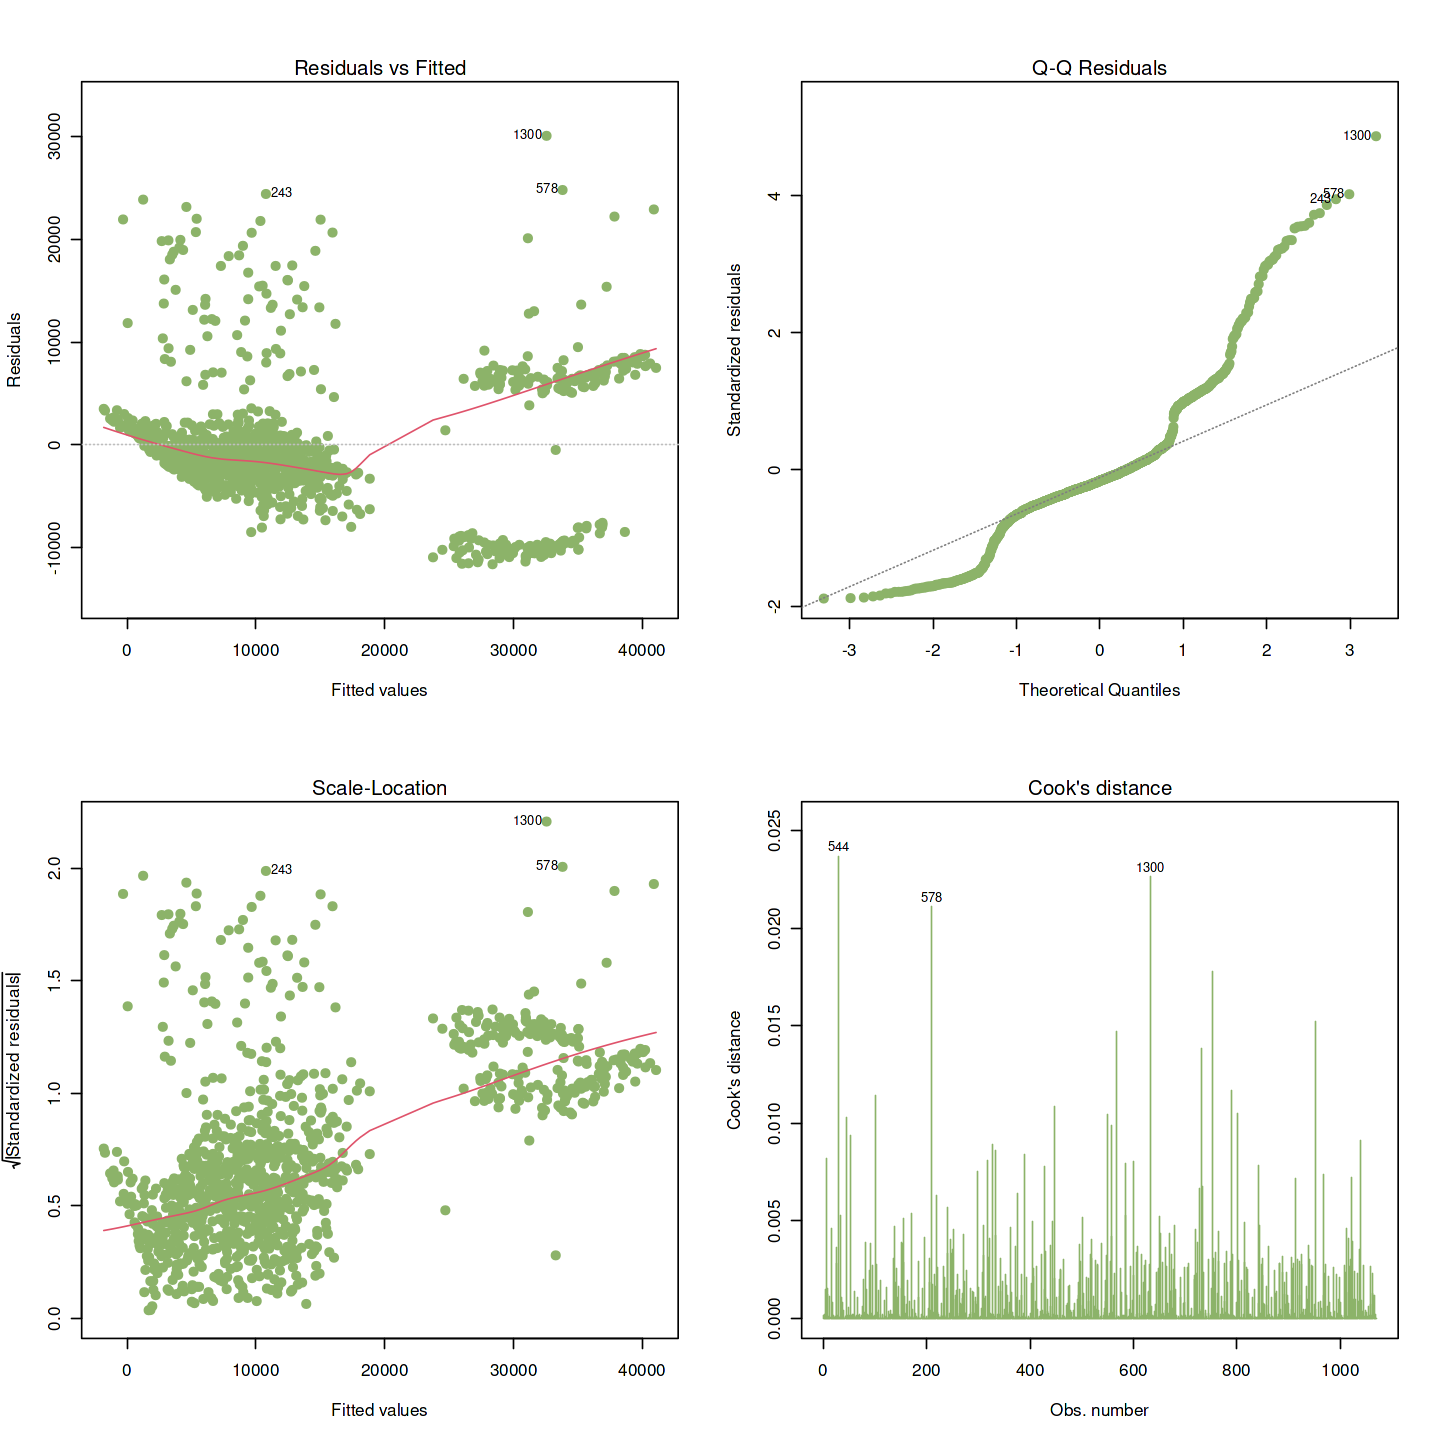

In [8]:
cat("\nMODEL DIAGNOSTICS\n")
cat("=" , rep("=", 50), "\n", sep = "")

# Diagnostic plots
par(mfrow = c(2, 2))
plot(model, which = 1:4, col = "#8cb369", pch = 19)
par(mfrow = c(1, 1))

# Normality test of residuals
shapiro_test <- shapiro.test(residuals(model))
cat("\nShapiro-Wilk Test (normality):\n")
cat("   p-value:", shapiro_test$p.value, "\n")

# Homoscedasticity test
bp_test <- bptest(model)
cat("\nBreusch-Pagan Test (homoscedasticity):\n")
cat("   p-value:", bp_test$p.value, "\n")

# VIF for multicollinearity
cat("\nVariance Inflation Factor (VIF):\n")
print(vif(model))

# **6. MODEL EVALUATION ON TEST SET**

In [9]:
cat("\nVALUATION ON TEST SET\n")
cat("=" , rep("=", 50), "\n", sep = "")

# Predictions
predictions <- predict(model, newdata = test_data)

# Performance metrics
rmse <- sqrt(mean((test_data$charges - predictions)^2))
mae <- mean(abs(test_data$charges - predictions))
r2 <- cor(test_data$charges, predictions)^2

cat("\nPERFORMANCE METRICS:\n")
cat("   RMSE:", dollar(rmse), "\n")
cat("   MAE:", dollar(mae), "\n")
cat("   R²:", round(r2, 4), "\n")


VALUATION ON TEST SET



PERFORMANCE METRICS:


   RMSE: $5,567.71 


   MAE: $3,884.80 


   R²: 0.7593 


# **7. FINAL VISUALIZATIONS**


🎨 GENERATING FINAL VISUALIZATIONS


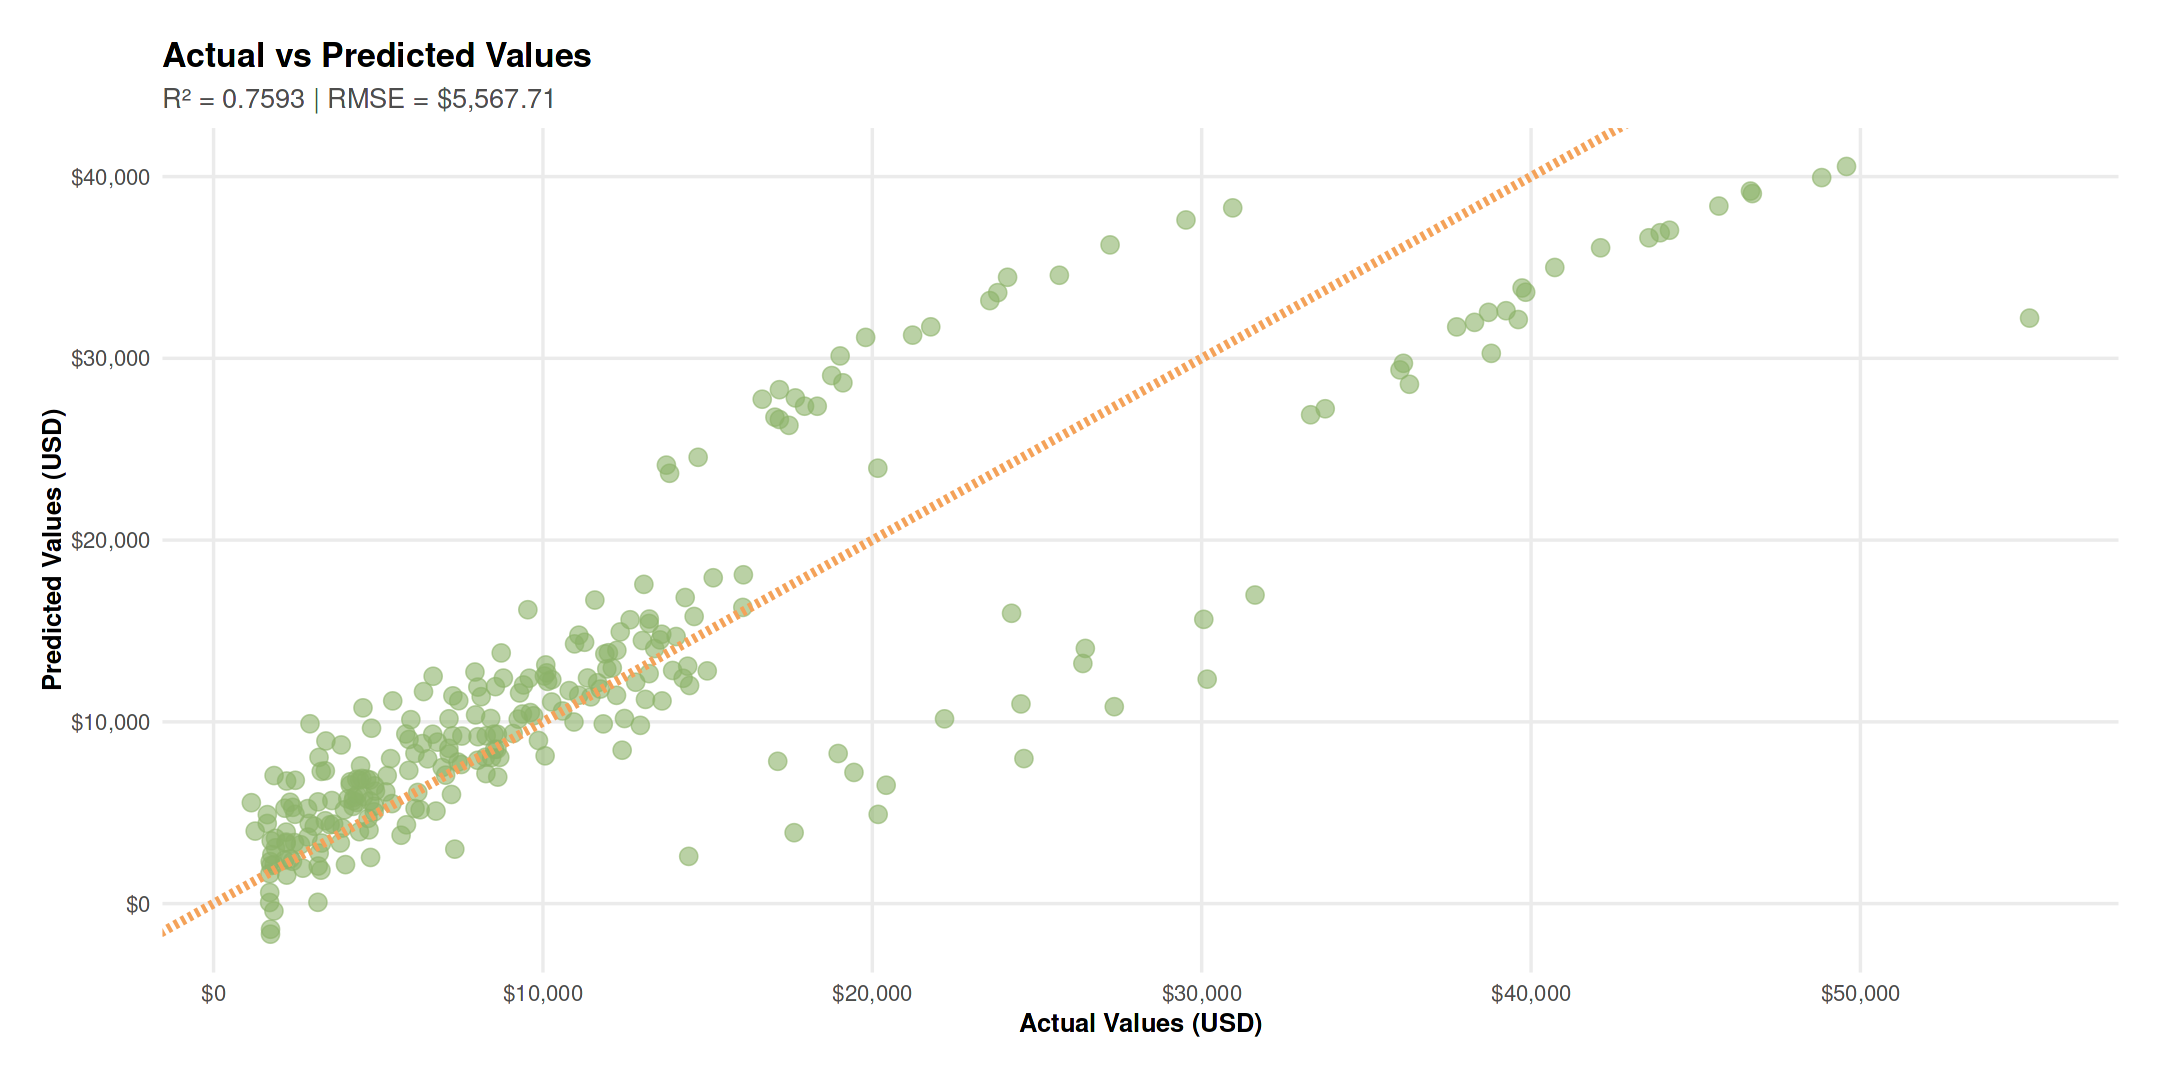

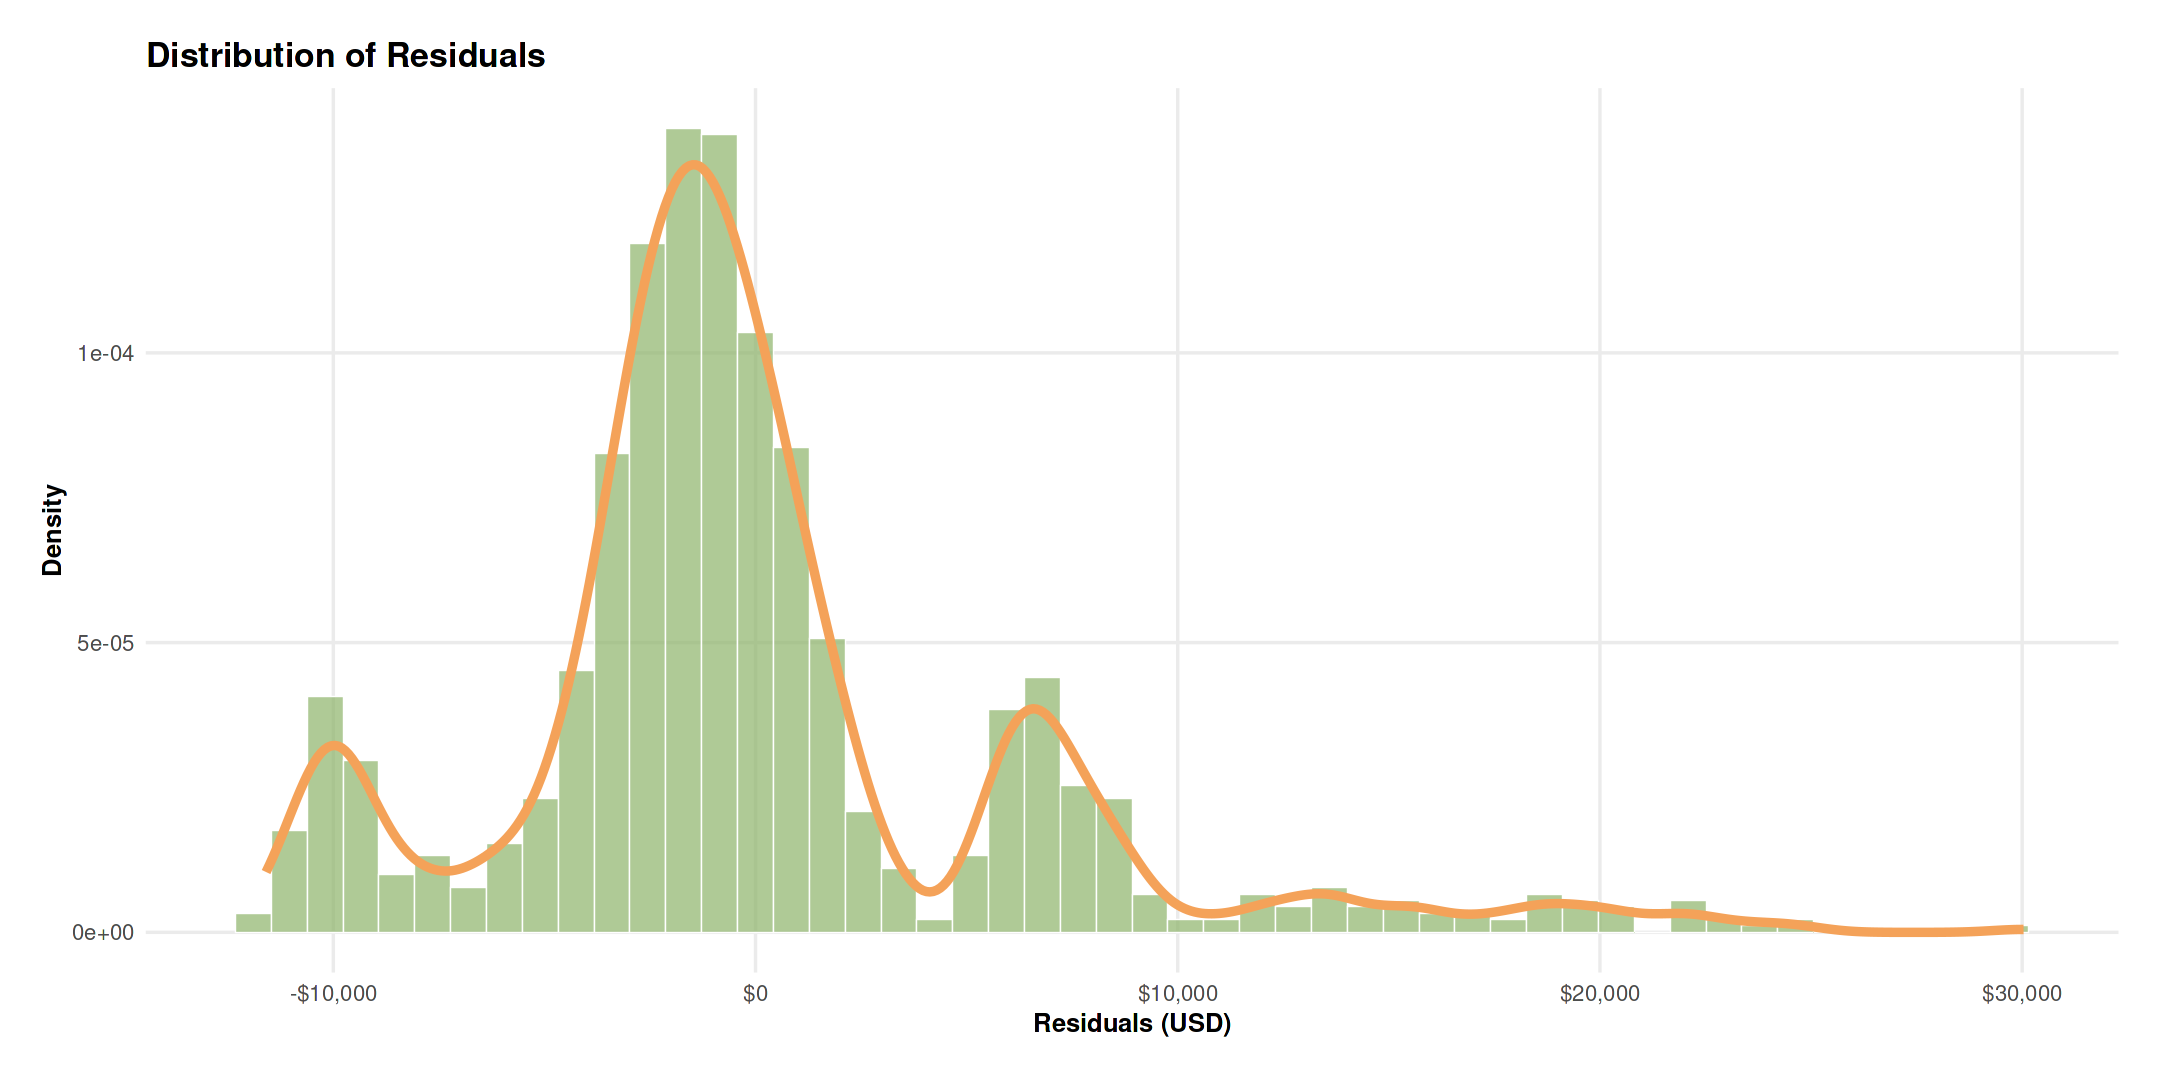

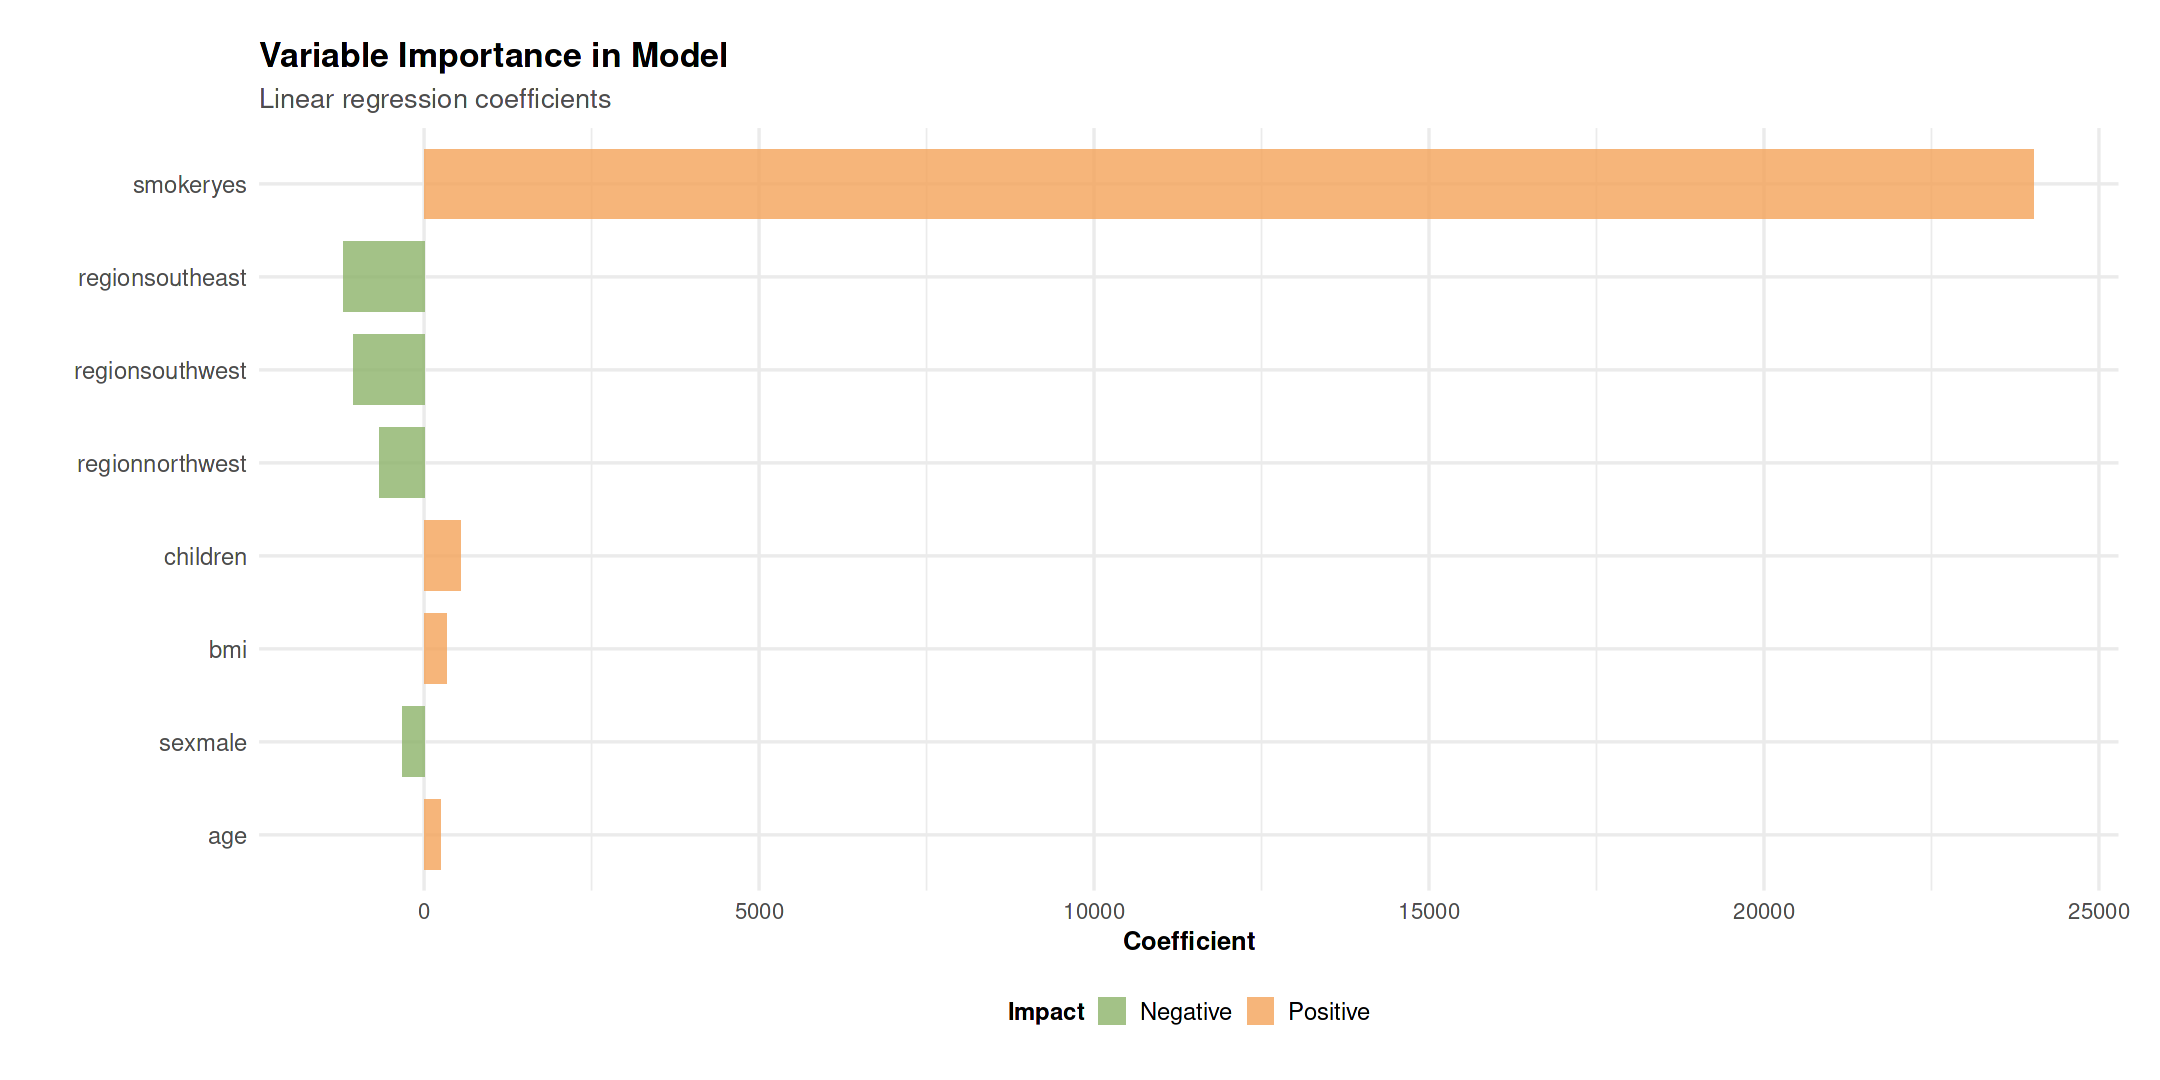

In [10]:
cat("\n🎨 GENERATING FINAL VISUALIZATIONS\n")
cat("=" , rep("=", 50), "\n", sep = "")

# 7.1 Actual vs predicted values - FULL WIDTH
options(repr.plot.width = 18, repr.plot.height = 9)
test_results <- data.frame(
  Actual = test_data$charges,
  Predicted = predictions
)

p5 <- ggplot(test_results, aes(x = Actual, y = Predicted)) +
  geom_point(alpha = 0.6, color = "#8cb369", size = 4.5) +
  geom_abline(intercept = 0, slope = 1, color = "#f4a259", 
              linewidth = 2, linetype = "dashed") +
  scale_x_continuous(labels = dollar_format(prefix = "$"),
                     breaks = seq(0, 70000, 10000)) +
  scale_y_continuous(labels = dollar_format(prefix = "$"),
                     breaks = seq(0, 70000, 10000)) +
  labs(title = "Actual vs Predicted Values",
       subtitle = sprintf("R² = %.4f | RMSE = %s", r2, dollar(rmse)),
       x = "Actual Values (USD)", y = "Predicted Values (USD)") +
  theme(panel.grid.minor = element_blank())

print(p5)

# 7.2 Distribution of residuals
residuals_df <- data.frame(Residuals = residuals(model))

p6 <- ggplot(residuals_df, aes(x = Residuals)) +
  geom_histogram(aes(y = after_stat(density)), bins = 50, 
                 fill = "#8cb369", alpha = 0.7, color = "white", linewidth = 0.3) +
  geom_density(color = "#f4a259", linewidth = 2) +
  scale_x_continuous(labels = dollar_format(prefix = "$")) +
  labs(title = "Distribution of Residuals",
       x = "Residuals (USD)", y = "Density") +
  theme(panel.grid.minor = element_blank())

print(p6)

# 7.3 Variable importance
coefficients <- data.frame(
  Variable = names(coef(model))[-1],
  Coefficient = coef(model)[-1]
) %>%
  arrange(desc(abs(Coefficient)))

p7 <- ggplot(coefficients, aes(x = reorder(Variable, abs(Coefficient)), 
                                y = Coefficient, fill = Coefficient > 0)) +
  geom_col(alpha = 0.8, width = 0.75) +
  coord_flip() +
  scale_fill_manual(values = c("#8cb369", "#f4a259"),
                    labels = c("Negative", "Positive")) +
  labs(title = "Variable Importance in Model",
       subtitle = "Linear regression coefficients",
       x = "", y = "Coefficient", fill = "Impact") +
  theme(legend.position = "bottom",
        legend.text = element_text(size = 14),
        axis.text = element_text(size = 13),
        axis.text.y = element_text(size = 14))

print(p7)